# Transfer learning of PhaseNet

In this notebook, the transfer learning process in seisbench will be explained. The Iquique dataset will be used to retrain the model. It should be noted that this dataset is not completely represent the chile subduction zone.

In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Model and data

We create a randomly initialized PhaseNet model using `seisbench.models`. If available, you can move your model onto the GPU for faster training.

In [29]:
#model = sbm.PhaseNet(phases="PSN")
model = sbm.PhaseNet.from_pretrained("instance")

model.cuda();

As training data we use the ETHZ dataset. Note that we set the sampling rate to 100 Hz to ensure that all examples are consistent in terms of sampling rate. We split the data into training, development and test sets according to the splits provided.

In [30]:
data = sbd.Iquique(sampling_rate=100)
#data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()

2022-09-16 11:33:38,817 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


In [31]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[2];

{'X': (array([[198.29475309, 203.29475309, 210.29475309, ..., -28.70524691,
        -43.70524691, -61.70524691],
       [-67.81648663, -50.81648663, -49.81648663, ..., -91.81648663,
        -80.81648663, -66.81648663],
       [ 81.47247942,  66.47247942,  56.47247942, ..., -75.52752058,
        -55.52752058, -43.52752058]]), {'source_origin_time': '2014-05-01T00:52:20.970000Z', 'source_latitude_deg': -19.4527, 'source_longitude_deg': -69.9762, 'source_depth_km': 57.95, 'path_back_azimuth_deg': 329.936310182, 'station_network_code': 'DG', 'station_code': 'IN17', 'trace_channel': 'HH*', 'station_location_code': nan, 'station_latitude_deg': -20.48, 'station_longitude_deg': -69.35, 'station_elevation_m': 1278.0, 'trace_name': 'bucket0$2,:3,:15552', 'trace_sampling_rate_hz': 100, 'trace_completeness': 1.0, 'trace_has_spikes': False, 'trace_start_time': '2014-05-01T00:52:20.740000Z', 'trace_P_arrival_sample': 2000.0, 'trace_S_arrival_sample': 3551.0, 'trace_name_original': 'DG.IN17.', 'trace

## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [32]:
'''
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
'''
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A normalization, consisting of demeaning and amplitude normalization.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label

In [33]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

Let's visualize a few training examples. Everytime you run the cell below, you'll see a different training example.

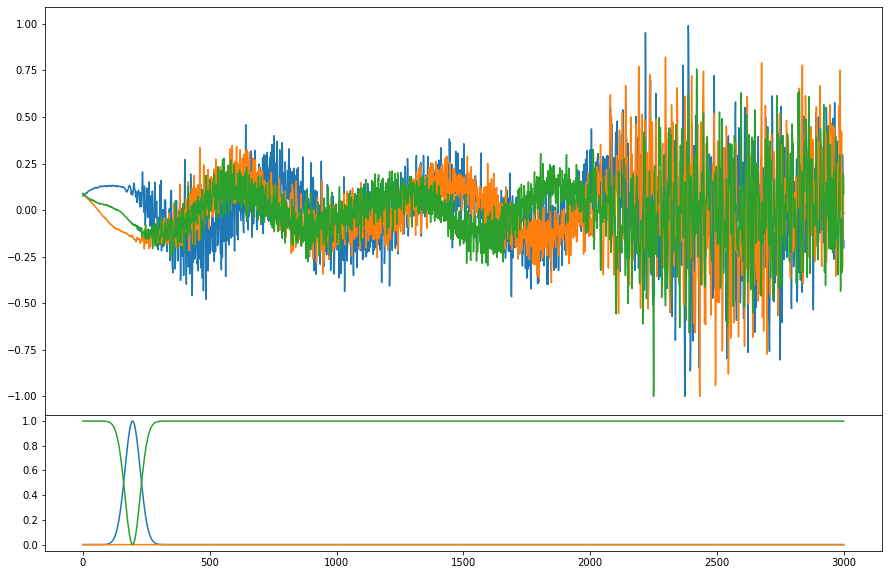

In [34]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 256 samples. This batch size should fit on most hardware.

In [35]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

## Training a model

Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [36]:
learning_rate = 1e-2
epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [37]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [38]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 0.086780  [    0/ 8040]
loss: 0.065620  [ 1280/ 8040]
loss: 0.060700  [ 2560/ 8040]
loss: 0.062376  [ 3840/ 8040]
loss: 0.056628  [ 5120/ 8040]
loss: 0.058285  [ 6400/ 8040]
loss: 0.057355  [ 7680/ 8040]
Test avg loss: 0.057421 

Epoch 2
-------------------------------
loss: 0.055407  [    0/ 8040]
loss: 0.057696  [ 1280/ 8040]
loss: 0.055521  [ 2560/ 8040]
loss: 0.058534  [ 3840/ 8040]
loss: 0.056879  [ 5120/ 8040]
loss: 0.056908  [ 6400/ 8040]
loss: 0.055999  [ 7680/ 8040]
Test avg loss: 0.056105 

Epoch 3
-------------------------------
loss: 0.057113  [    0/ 8040]
loss: 0.056632  [ 1280/ 8040]
loss: 0.058115  [ 2560/ 8040]
loss: 0.057666  [ 3840/ 8040]
loss: 0.056434  [ 5120/ 8040]
loss: 0.057059  [ 6400/ 8040]
loss: 0.059127  [ 7680/ 8040]
Test avg loss: 0.056159 

Epoch 4
-------------------------------
loss: 0.056012  [    0/ 8040]
loss: 0.056706  [ 1280/ 8040]
loss: 0.054342  [ 2560/ 8040]
loss: 0.054585  [ 3840/ 8040]
loss: 0.0567

## Evaluating the model

Not that we trained the model, we can evaluate it. First, we'll check how the model does on an example from the development set. Note that the model will most likely not be fully trained after only five epochs.

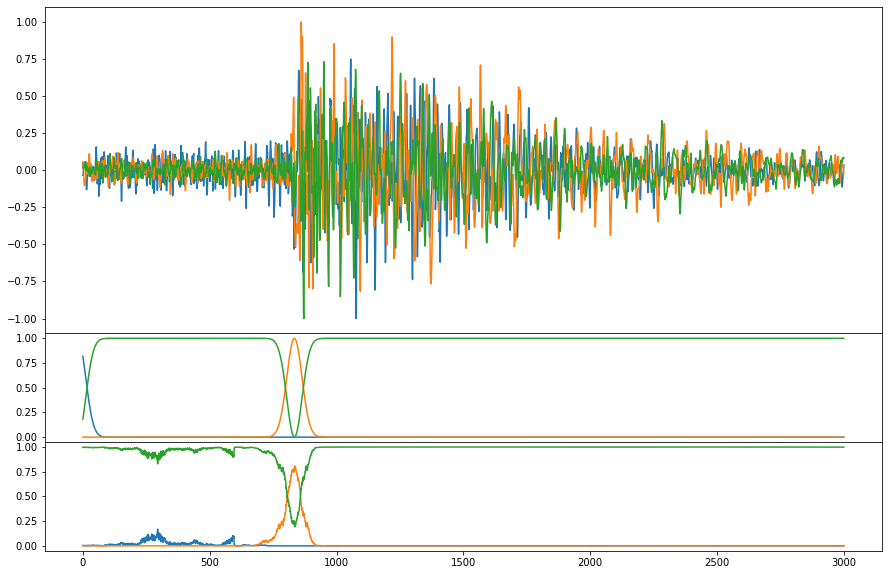

In [51]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

As we trained the model on Swiss data, we use an example event from Switzerland. Note that we deliberately chose a rather easy example, as the model is not fully trained after the low number of epochs. The exact performance of the model will vary depending, because the model training and initialization involves random aspects.

In [52]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)
out = model.annotate(stream)
out[0]

CH.EMING..PhaseNet_P | 2019-11-04T00:59:16.420000Z - 2019-11-04T01:00:36.420000Z | 100.0 Hz, 8001 samples

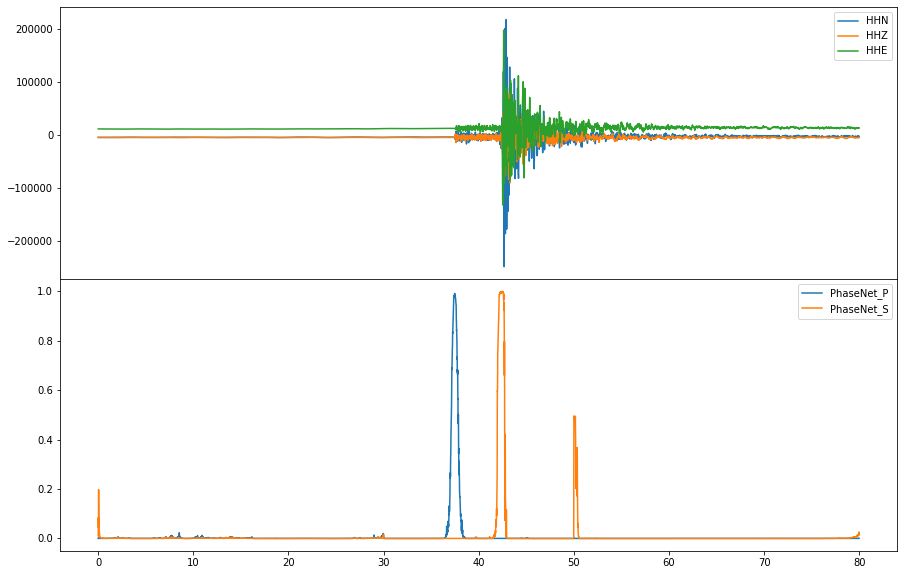

In [42]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [43]:
offset

0.0

## Remarks

As discussed in the data basics tutorial, loading a SeisBench dataset only means loading the metadata into memory. The waveforms are only loaded once they are requested to save memory. By default, waveforms are **not** cached in memory. For training, this means that the data needs to be read from the file in every epoch again. Depending on your hardware, this will take a lot of time. To solve this issue, you can set the `cache` option, when creating the dataset. Then, all you have to do is call `preload_waveforms` and the data will be loaded into memory and automatically cached. For most practical applications, this option is recommended.